In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Warm-up

In [4]:
df_citibike = pd.read_csv("202307-citibike-tripdata.csv")

C:\Users\User\AppData\Local\Temp\ipykernel_11720\2232755120.py:1: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_citibike = pd.read_csv("202307-citibike-tripdata.csv")


In [5]:
df_citibike.started_at = pd.to_datetime(df_citibike.started_at)
df_citibike.ended_at = pd.to_datetime(df_citibike.ended_at)

In [6]:
df_citibike.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,BC78328130CD8A16,classic_bike,2023-07-16 20:42:57,2023-07-16 20:45:13,St. Nicholas Ave & W 126 St,7756.10,Adam Clayton Powell Blvd & W 126 St,7738.04,40.811432,-73.951878,40.809495,-73.947765,member
1,71A4DFA231ADAEA2,classic_bike,2023-07-29 12:22:21,2023-07-29 12:26:54,Adam Clayton Powell Blvd & W 118 St,7670.09,Adam Clayton Powell Blvd & W 126 St,7738.04,40.804372,-73.951475,40.809495,-73.947765,member
2,B64451D0D9F52134,classic_bike,2023-07-30 18:30:18,2023-07-30 18:35:42,St. Nicholas Ave & W 126 St,7756.10,Lenox Ave & W 130 St,7753.13,40.811378,-73.951827,40.810792,-73.943068,member
3,EEECB3E0E05EB0DB,classic_bike,2023-07-04 19:59:20,2023-07-04 20:02:03,St. Nicholas Ave & W 126 St,7756.10,Adam Clayton Powell Blvd & W 126 St,7738.04,40.811432,-73.951878,40.809495,-73.947765,member
4,76B706DF4FC180DC,classic_bike,2023-07-03 19:33:36,2023-07-03 19:43:59,St. Nicholas Ave & W 126 St,7756.10,Pleasant Ave & E 116 St,7450.05,40.811543,-73.951813,40.794988,-73.933335,member


In [7]:
df_citibike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3776256 entries, 0 to 3776255
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       object        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    object        
 6   end_station_name    object        
 7   end_station_id      object        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       object        
dtypes: datetime64[ns](2), float64(4), object(7)
memory usage: 374.5+ MB


In [8]:
df_citibike = df_citibike.dropna()

In [9]:
df_citibike["duration"] = (df_citibike.ended_at - df_citibike.started_at).dt.total_seconds() / 60

In [10]:
df_citibike.duration

0           2.266667
1           4.550000
2           5.400000
3           2.716667
4          10.383333
             ...    
3776251    26.650000
3776252    28.316667
3776253     4.450000
3776254    10.683333
3776255     2.566667
Name: duration, Length: 3767347, dtype: float64

In [11]:
df_citibike = df_citibike[df_citibike.duration < 60*3]
df_citibike = df_citibike[df_citibike.duration > 0]

## Duration Histogram

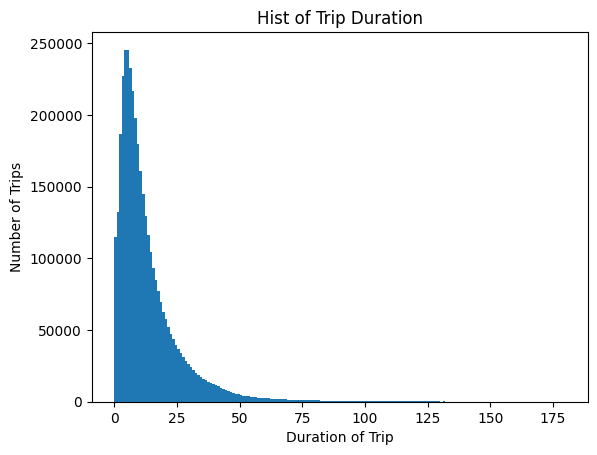

In [12]:
plt.hist(df_citibike.duration, bins=3*60)
plt.title("Hist of Trip Duration")
plt.xlabel("Duration of Trip")
plt.ylabel("Number of Trips")
plt.show()

## Average Ride Duration, Variance, and $\mathbb{P}$(Duration $>$ 20)

In [13]:
total = len(df_citibike)

In [14]:
avg_dur = df_citibike.duration.mean()
print(f"Average Duration = {avg_dur}")

Average Duration = 13.560221346513465


In [15]:
var_dur = df_citibike.duration.var()
print(f"Varianve of Duration = {var_dur}")

Varianve of Duration = 196.69836284899702


In [16]:
gt_20 = (df_citibike.duration > 20).sum()
p_dur_20 = gt_20 / total
print(f"P(duration > 20) = {p_dur_20}")

P(duration > 20) = 0.19654085290380166


## $\mathbb{P}$(Duration > 20 | CitiBike Memeber)

In [17]:
p_citibike_mem = (df_citibike.member_casual == "member").sum() / total
p_cbmem_and_dur20 = ((df_citibike.member_casual == "member") & (df_citibike.duration > 20)).sum() / total
p_dur20_given_citibike_mem = p_cbmem_and_dur20 / p_citibike_mem
print(f"P(duration > 20 | CitiBike Member) = {p_dur20_given_citibike_mem}")

P(duration > 20 | CitiBike Member) = 0.1546848321918055


## $\mathbb{P}$(CitiBike Member | Duration > 25)

In [18]:
p_dur_25 = (df_citibike.duration > 25).sum() / total
p_cbmem_and_dur25 = ((df_citibike.member_casual == "member") & (df_citibike.duration > 25)).sum() / total
p_dur25_given_citibike_mem = p_cbmem_and_dur25 / p_dur_25
print(f"P(CitiBike Member | duration > 25) = {p_dur25_given_citibike_mem}")

P(CitiBike Member | duration > 25) = 0.5787196676877677


## Expected duration of Electric Bike vs. Classic Bike

In [19]:
df_elecbike = df_citibike[df_citibike.rideable_type == "electric_bike"]
df_clasbike = df_citibike[df_citibike.rideable_type == "classic_bike"]

In [20]:
avg_dur_eb = df_elecbike.duration.mean()
avg_dur_cb = df_clasbike.duration.mean()
print(f"Expected Duration: ebike={avg_dur_eb} ; classic-bike={avg_dur_cb}")

Expected Duration: ebike=12.280488130239785 ; classic-bike=13.63475766258535


## $\mathbb{P}$(Electric Bike | Duration < 10) and $\mathbb{P}$(Classic Bike | Duration < 10)

In [21]:
p_d10 = (df_citibike.duration < 10).sum() / total
p_eb_and_d10 = ((df_citibike.rideable_type == "electric_bike") & (df_citibike.duration < 10)).sum() / total
p_cb_and_d10 = ((df_citibike.rideable_type == "classic_bike") & (df_citibike.duration < 10)).sum() / total
p_eb_given_d10 = p_eb_and_d10 / p_d10
p_cb_given_d10 = p_cb_and_d10 / p_d10
print(f"P(E-bike | duration < 10)={p_eb_given_d10}\nP(classic-bike | duration < 10)={p_cb_given_d10}")

P(E-bike | duration < 10)=0.08921668362156664
P(classic-bike | duration < 10)=0.9101774950274062


# Project Portion

## Select Stations

In [22]:
df_start = df_citibike.groupby(["start_station_id", "start_station_name"]).ride_id.count().sort_values(ascending=False)

In [23]:
df_start.head(25)

start_station_id  start_station_name         
6140.05           W 21 St & 6 Ave                12453
5329.03           West St & Chambers St          12361
6948.10           Broadway & W 58 St             11097
6726.01           11 Ave & W 41 St               10559
6364.07           6 Ave & W 33 St                10130
6765.01           12 Ave & W 40 St               10015
6157.04           10 Ave & W 14 St                9999
5184.08           West St & Liberty St            9752
5905.14           University Pl & E 14 St         9682
6912.01           7 Ave & Central Park South      9656
6822.09           1 Ave & E 68 St                 9631
5980.07           E 17 St & Broadway              9308
6173.08           Broadway & W 25 St              8960
6459.07           W 30 St & 10 Ave                8929
5696.03           Pier 40 - Hudson River Park     8904
5905.12           Broadway & E 14 St              8686
5492.05           Cleveland Pl & Spring St        8682
6331.01           W

In [24]:
df_end = df_citibike.groupby(["end_station_id", "end_station_name"]).ride_id.count().sort_values(ascending=False)

In [25]:
df_end.head(25)

end_station_id  end_station_name           
6140.05         W 21 St & 6 Ave                13658
6948.10         Broadway & W 58 St             12028
6726.01         11 Ave & W 41 St               11967
6912.01         7 Ave & Central Park South     11391
6364.07         6 Ave & W 33 St                11091
6765.01         12 Ave & W 40 St               10899
5905.14         University Pl & E 14 St        10548
6822.09         1 Ave & E 68 St                10403
5980.07         E 17 St & Broadway             10242
6459.07         W 30 St & 10 Ave               10003
5905.12         Broadway & E 14 St              9642
5492.05         Cleveland Pl & Spring St        9588
6331.01         W 31 St & 7 Ave                 9576
6197.08         E 33 St & 1 Ave                 9527
6535.04         W 34 St & Hudson Blvd E         9090
6450.12         8 Ave & W 33 St                 9079
5696.03         Pier 40 - Hudson River Park     8995
5788.13         Lafayette St & E 8 St           8929
64

Stations Selected
- 6948.10, Broadway & W 58 St, 11097
- 5184.08, West St & Liberty St 9752
- 5696.03, Pier 40 - Hudson River Park, 8995

In [102]:
station_1_id = "6948.10"
station_2_id = "5184.08"
station_3_id = "5696.03"
station_ids = [station_1_id, station_2_id, station_3_id]
station_map = {
    '6948.10': {
        "station_name": 'Broadway & W 58 St', 
        "dock_size": 53
    },
    '5184.08': {
        "station_name": 'West St & Liberty St', 
        "dock_size": 34
    },
    '5696.03': {
        "station_name": 'Pier 40 - Hudson River Park', 
        "dock_size": 19
    },
}

In [70]:
mask_st = df_citibike.start_station_id.isin(station_ids)
mask_end = df_citibike.end_station_id.isin(station_ids)
df_stations = df_citibike[mask_st | mask_end].reset_index(drop=True)

In [71]:
df_stations = df_stations.drop(["start_lat", "start_lng", "end_lat", "end_lng"], axis=1)

## Remove Weekends

In [73]:
df_stations["weekday_start"] = df_stations["started_at"].dt.dayofweek
df_stations["weekday_end"] = df_stations["ended_at"].dt.dayofweek
mask_st = (df_stations.weekday_start < 5) & (df_stations.start_station_id.isin(station_ids))
mask_end = (df_stations.weekday_end < 5) & (df_stations.end_station_id.isin(station_ids))
df_stations = df_stations[mask_st | mask_end]

## Extract 5 min intervals

In [74]:
# Extract the time part
df_stations['start_bin'] = ((df_stations['started_at'].dt.hour * 60 + df_stations['started_at'].dt.minute) // 5)
df_stations['end_bin'] = ((df_stations['ended_at'].dt.hour * 60 + df_stations['ended_at'].dt.minute) // 5)

C:\Users\User\AppData\Local\Temp\ipykernel_11720\971441422.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stations['start_bin'] = ((df_stations['started_at'].dt.hour * 60 + df_stations['started_at'].dt.minute) // 5)
C:\Users\User\AppData\Local\Temp\ipykernel_11720\971441422.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stations['end_bin'] = ((df_stations['ended_at'].dt.hour * 60 + df_stations['ended_at'].dt.minute) // 5)


In [75]:
df_stations.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,member_casual,duration,weekday_start,weekday_end,start_bin,end_bin
0,D885F77723C75623,classic_bike,2023-07-11 19:11:32,2023-07-11 19:17:07,Pier 40 - Hudson River Park,5696.03,Greenwich St & Hubert St,5470.10,member,5.583333,1,1,230,231
1,6F662CC1D61C7D14,classic_bike,2023-07-07 07:26:31,2023-07-07 07:29:46,Pier 40 - Hudson River Park,5696.03,Greenwich St & Hubert St,5470.10,casual,3.250000,4,4,89,89
2,783552ECABCB36BC,classic_bike,2023-07-12 08:09:08,2023-07-12 08:23:59,Pier 40 - Hudson River Park,5696.03,Lafayette St & Grand St,5422.09,member,14.850000,2,2,97,100
4,0113D2FBD4E513F7,classic_bike,2023-07-04 13:04:56,2023-07-04 13:27:59,Pier 40 - Hudson River Park,5696.03,W 54 St & 9 Ave,6920.03,casual,23.050000,1,1,156,161
5,39DEEDF03DFA35E7,classic_bike,2023-07-18 21:18:27,2023-07-18 21:25:56,Pier 40 - Hudson River Park,5696.03,W 20 St & 10 Ave,6306.01,member,7.483333,1,1,255,257


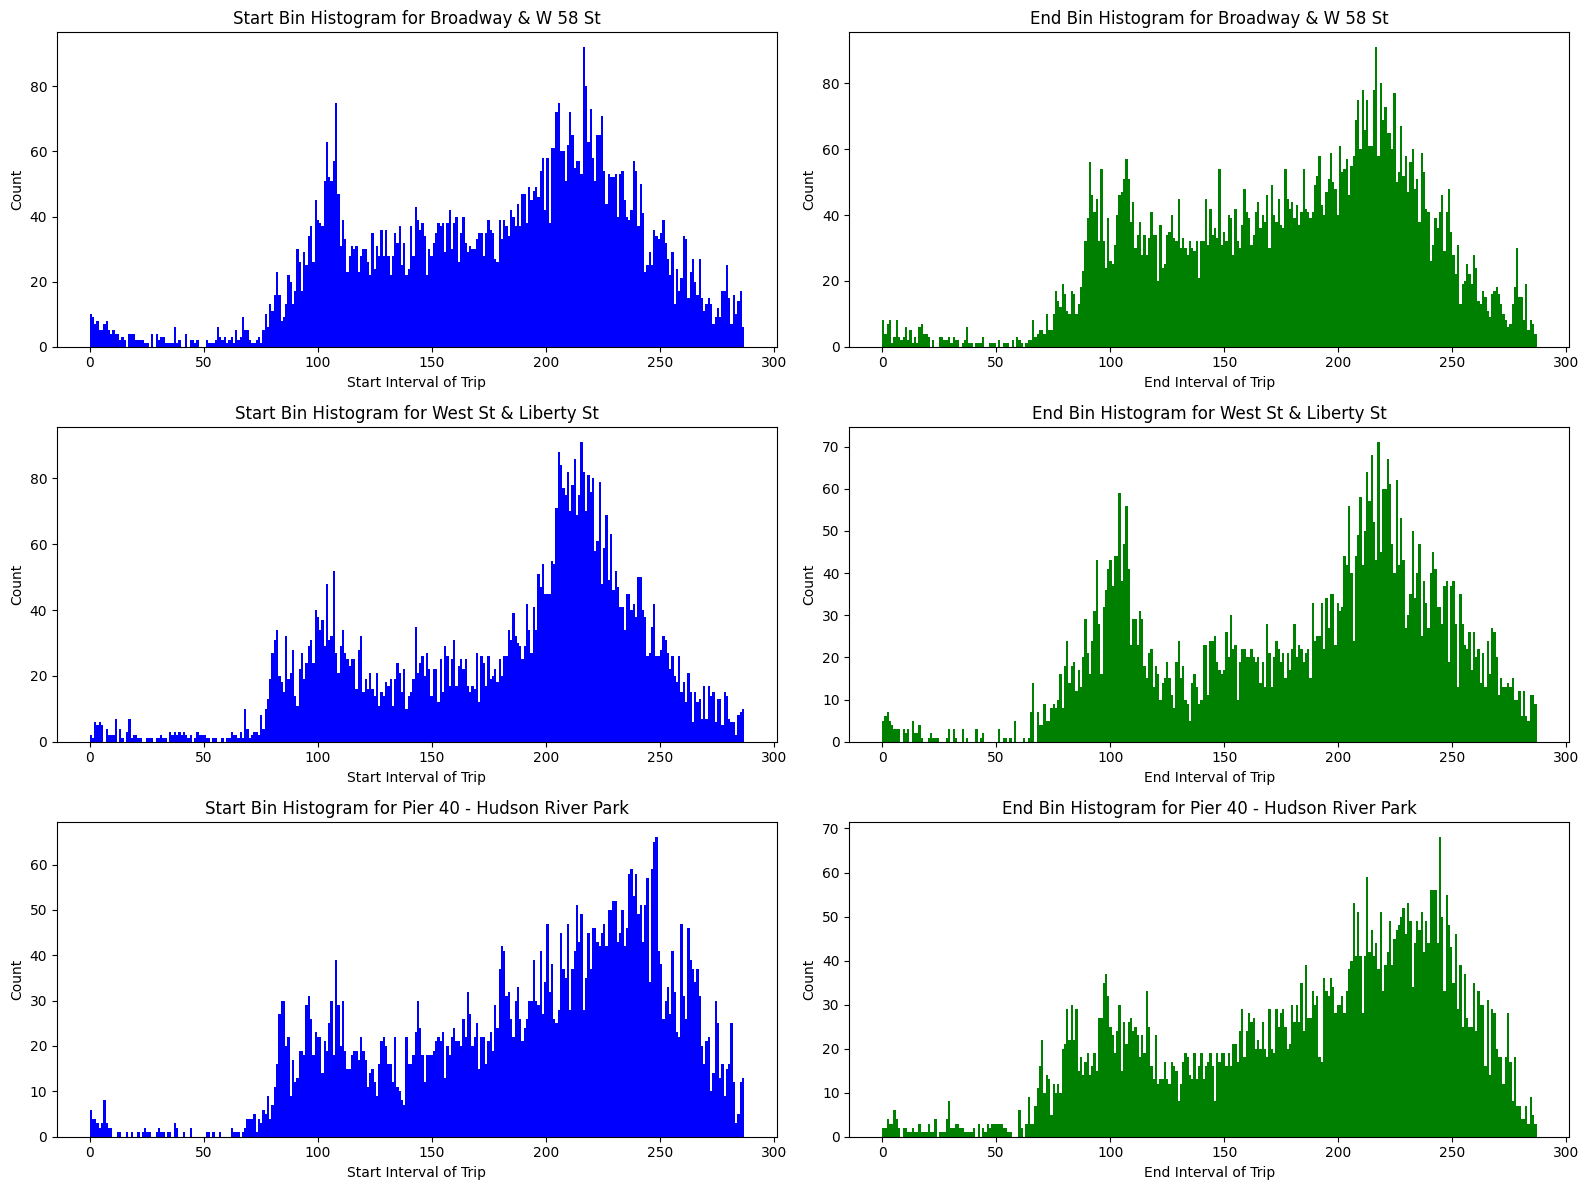

In [76]:
plt.figure(figsize=(16, 12))
for i, station_id in enumerate(station_ids):
    # Create masks for trips that start or end at the current station
    mask_st = df_stations['start_station_id'] == station_id
    mask_end = df_stations['end_station_id'] == station_id

    # Histogram for start bin (1st column)
    plt.subplot(3, 2, 2*i + 1)  # 3 rows, 2 columns, subplot index for start bin
    plt.hist(df_stations[mask_st].start_bin, bins=24*60//5, color='blue')
    plt.title(f"""Start Bin Histogram for {station_map[station_id].get("station_name")}""")
    plt.xlabel('Start Interval of Trip')
    plt.ylabel('Count')

    # Histogram for end bin (2nd column)
    plt.subplot(3, 2, 2*i + 2)  # 3 rows, 2 columns, subplot index for end bin
    plt.hist(df_stations[mask_end].end_bin, bins=288, color='green')
    plt.title(f"""End Bin Histogram for {station_map[station_id].get("station_name")}""")
    plt.xlabel('End Interval of Trip')
    plt.ylabel('Count')

plt.tight_layout()  # Adjust layout
plt.show()

## Split Morning and Evening
- Morning: 78 - 150 (6:30am - 12:30pm)
- Evening: 192 - 264 (4:00pm - 10:00pm)

In [86]:
mask_morning_st = (78 <= df_stations.start_bin) & (df_stations.start_bin <= 150) & (df_stations.start_station_id.isin(station_ids))
mask_morning_end = (78 <= df_stations.end_bin) & (df_stations.end_bin <= 150) & (df_stations.end_station_id.isin(station_ids))

mask_evening_st = (192 <= df_stations.start_bin) & (df_stations.start_bin <= 264) & (df_stations.start_station_id.isin(station_ids))
mask_evening_end = (192 <= df_stations.end_bin) & (df_stations.end_bin <= 264) & (df_stations.end_station_id.isin(station_ids))

df_stations_morn = df_stations[mask_morning_st | mask_morning_end]
df_stations_even = df_stations[mask_evening_st | mask_evening_end]

In [87]:
mask_1_st = (df_stations.start_station_id == station_1_id)
mask_1_end = (df_stations.end_station_id == station_1_id)
df_s1_m = df_stations_morn[mask_1_st | mask_1_end]
df_s1_e = df_stations_even[mask_1_st | mask_1_end]

C:\Users\User\AppData\Local\Temp\ipykernel_11720\2866090712.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_s1_m = df_stations_morn[mask_1_st | mask_1_end]
C:\Users\User\AppData\Local\Temp\ipykernel_11720\2866090712.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_s1_e = df_stations_even[mask_1_st | mask_1_end]


In [89]:
print(f"Morning points: {len(df_s1_m)} ; Evening Points: {len(df_s1_e)}")

Morning points: 4442 ; Evening Points: 6644


In [100]:
(df_s1_m.end_station_id == station_1_id).sum()

2413

In [90]:
mask_2_st = (df_stations.start_station_id == station_2_id)
mask_2_end = (df_stations.end_station_id == station_2_id)
df_s2_m = df_stations_morn[mask_2_st | mask_2_end]
df_s2_e = df_stations_even[mask_2_st | mask_2_end]

C:\Users\User\AppData\Local\Temp\ipykernel_11720\69442206.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_s2_m = df_stations_morn[mask_2_st | mask_2_end]
C:\Users\User\AppData\Local\Temp\ipykernel_11720\69442206.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_s2_e = df_stations_even[mask_2_st | mask_2_end]


In [91]:
print(f"Morning points: {len(df_s2_m)} ; Evening Points: {len(df_s2_e)}")

Morning points: 3292 ; Evening Points: 6119


In [92]:
mask_3_st = (df_stations.start_station_id == station_3_id)
mask_3_end = (df_stations.end_station_id == station_3_id)
df_s3_m = df_stations_morn[mask_3_st | mask_3_end]
df_s3_e = df_stations_even[mask_3_st | mask_3_end]

C:\Users\User\AppData\Local\Temp\ipykernel_11720\2107300157.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_s3_m = df_stations_morn[mask_3_st | mask_3_end]
C:\Users\User\AppData\Local\Temp\ipykernel_11720\2107300157.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_s3_e = df_stations_even[mask_3_st | mask_3_end]


In [93]:
print(f"Morning points: {len(df_s3_m)} ; Evening Points: {len(df_s3_e)}")

Morning points: 2724 ; Evening Points: 5773
